In [1]:
%%HTML
<style> .output {flex-direction: row} </style>

<img style="margin-left: auto; margin-right: auto; width=50%" src="uproot-3.png"></img>

What's new?

   * more modularization
   * writing files
   * jagged array operations

## More modularization

uproot 2 had been a single library (optionally depending on lz4).

<img style="margin-left: auto; margin-right: auto; width=80%" src="abstraction-layers-before.png"></img>

## More modularization

uproot 3 splits out everything that is not I/O. We'll see the advantage in a moment.

<img style="margin-left: auto; margin-right: auto; width=80%" src="abstraction-layers.png"></img>

## Writing files

uproot can now write histograms to files. It has the same dict-like interface as reading:

In [2]:
import uproot
import numpy

f = uproot.recreate("tmp.root")                                  # instead of uproot.open
f["name"] = numpy.histogram(numpy.random.normal(0, 1, 100000))   # any kind of histogram

In [3]:
f["name"].show()                                                 # read it back out

                            0                                              31602
                            +--------------------------------------------------+
[-inf, -4.2065)       0     |                                                  |
[-4.2065, -3.364)     34    |                                                  |
[-3.364, -2.5215)     512   |*                                                 |
[-2.5215, -1.6789)    4043  |******                                            |
[-1.6789, -0.83644)   15480 |************************                          |
[-0.83644, 0.0060636) 30097 |************************************************  |
[0.0060636, 0.84857)  29887 |***********************************************   |
[0.84857, 1.6911)     15330 |************************                          |
[1.6911, 2.5336)      4053  |******                                            |
[2.5336, 3.3761)      528   |*                                                 |
[3.3761, 4.2186)      36    

In [4]:
import ROOT
c = ROOT.TCanvas()

Welcome to JupyROOT 6.14/04


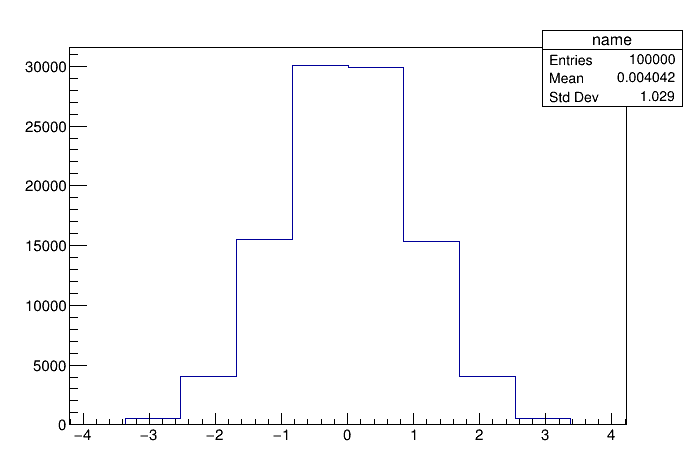

In [5]:
f = ROOT.TFile("tmp.root")                    # ROOT can read it, too
h = f.Get("name")
h.Draw()
c.Draw()

In [6]:
f = ROOT.TFile("tmp.root", "UPDATE")          # ROOT can add to the same file, too
h = ROOT.TH1D("another", "", 10, -5, 5)
for x in numpy.random.normal(0, 1, 100000):
    h.Fill(x)
h.Write()
f.Close()

In [7]:
f = uproot.open("tmp.root")
f["another"].show()

                 0                                                         36060
                 +-------------------------------------------------------------+
[-inf, -5) 0     |                                                             |
[-5, -4)   4     |                                                             |
[-4, -3)   123   |                                                             |
[-3, -2)   2091  |****                                                         |
[-2, -1)   13405 |***********************                                      |
[-1, 0)    34343 |**********************************************************   |
[0, 1)     34227 |**********************************************************   |
[1, 2)     13542 |***********************                                      |
[2, 3)     2136  |****                                                         |
[3, 4)     126   |                                                             |
[4, 5)     3     |          

uproot could become a clearinghouse for histograms from different libraries.

In [8]:
%matplotlib inline
import physt                    # https://physt.readthedocs.io

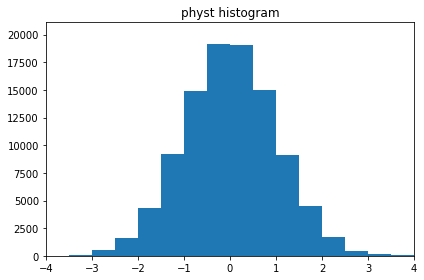

In [10]:
h = physt.h1(numpy.random.normal(0, 1, 100000),
             bins=16, range=(-4, 4), name="physt histogram")
h.plot();

In [11]:
f = uproot.recreate("tmp.root")   # save it as a TH1D
f["name"] = h

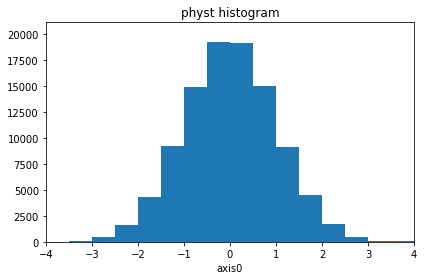

In [13]:
f = uproot.open("tmp.root")       # read it back and convert it back to physt
f["name"].physt().plot();

In [14]:
f["name"].numpy()                  # or numpy

(array([   22,   103,   493,  1643,  4335,  9171, 14928, 19189, 19088,
        15032,  9154,  4533,  1675,   465,   124,    35], dtype=int32),
 array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,
         1.5,  2. ,  2.5,  3. ,  3.5,  4. ]))

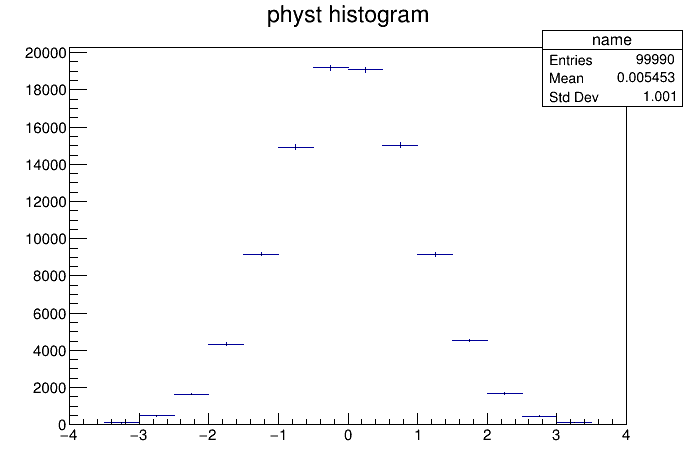

In [15]:
f = ROOT.TFile("tmp.root")         # but look, it's really ROOT
h = f.Get("name")
h.Draw()
c.Draw()

This can also include new ways of looking at histograms.

In [16]:
f = uproot.open("tmp.root")
print(f["name"].hepdata())      # YAML format for the HEPData archival site

dependent_variables:
- header: {name: counts, units: null}
  qualifiers: []
  values:
  - errors:
    - {label: stat, symerror: 4.69041575982343}
    value: 22.0
  - errors:
    - {label: stat, symerror: 10.14889156509222}
    value: 103.0
  - errors:
    - {label: stat, symerror: 22.20360331117452}
    value: 493.0
  - errors:
    - {label: stat, symerror: 40.53393639902249}
    value: 1643.0
  - errors:
    - {label: stat, symerror: 65.84071688552609}
    value: 4335.0
  - errors:
    - {label: stat, symerror: 95.7653381970742}
    value: 9171.0
  - errors:
    - {label: stat, symerror: 122.18019479441011}
    value: 14928.0
  - errors:
    - {label: stat, symerror: 138.52436608770313}
    value: 19189.0
  - errors:
    - {label: stat, symerror: 138.15932831336434}
    value: 19088.0
  - errors:
    - {label: stat, symerror: 122.60505699195282}
    value: 15032.0
  - errors:
    - {label: stat, symerror: 95.67653839891993}
    value: 9154.0
  - errors:
    - {label: stat, symerror: 6

This includes an idea I've been working on in which Pandas DataFrames with an interval index _are_ histograms.

In [17]:
f = uproot.open("tmp.root")         # read as histogram
h = f["name"].pandas()
h

,count,variance
physt histogram,,
"[-inf, -4.0)",6,0.0
"[-4.0, -3.5)",22,22.0
"[-3.5, -3.0)",103,103.0
"[-3.0, -2.5)",493,493.0
"[-2.5, -2.0)",1643,1643.0
"[-2.0, -1.5)",4335,4335.0
"[-1.5, -1.0)",9171,9171.0
"[-1.0, -0.5)",14928,14928.0
"[-0.5, 0.0)",19189,19189.0


In [18]:
f = uproot.recreate("tmp.root")     # write as histogram
f["another"] = h

Given the way Pandas handles indexes (interval indexes in particular), Pandas-as-histograms are sparse histograms.

In [53]:
f = uproot.recreate("tmp.root")
f["one"]   = numpy.histogram(numpy.random.normal(1, 0.6, 10000), bins=8, range=(0, 8))
f["two"]   = numpy.histogram(numpy.random.normal(3, 0.4, 10000), bins=8, range=(0, 8))
f["three"] = numpy.histogram(numpy.random.normal(9, 0.6, 100000), bins=8, range=(0, 8))
one   = f["one"].pandas()
two   = f["two"].pandas()
three = f["three"].pandas()

In [54]:
from IPython.display import display
display(one); display(two); display(three);

,count,variance
"[0.0, 1.0)",4505,4505
"[1.0, 2.0)",4523,4523
"[2.0, 3.0)",491,491
"[3.0, 4.0)",3,3


,count,variance
"[1.0, 2.0)",53,53
"[2.0, 3.0)",4968,4968
"[3.0, 4.0)",4916,4916
"[4.0, 5.0)",63,63


,count,variance
"[6.0, 7.0)",47,47
"[7.0, 8.0)",4807,4807


Adding DataFrames matches up intervals and fills in missing values with NaN (0 if we explicitly set it).

In [55]:
import functools
def add(*args):
    return functools.reduce(lambda x, y: x.add(y, fill_value=0), args)

display(add(one, two)); display(add(two, three)); display(add(one, two, three))

,count,variance
"[0.0, 1.0)",4505.0,4505.0
"[1.0, 2.0)",4576.0,4576.0
"[2.0, 3.0)",5459.0,5459.0
"[3.0, 4.0)",4919.0,4919.0
"[4.0, 5.0)",63.0,63.0


,count,variance
"[1.0, 2.0)",53.0,53.0
"[2.0, 3.0)",4968.0,4968.0
"[3.0, 4.0)",4916.0,4916.0
"[4.0, 5.0)",63.0,63.0
"[6.0, 7.0)",47.0,47.0
"[7.0, 8.0)",4807.0,4807.0


,count,variance
"[0.0, 1.0)",4505.0,4505.0
"[1.0, 2.0)",4576.0,4576.0
"[2.0, 3.0)",5459.0,5459.0
"[3.0, 4.0)",4919.0,4919.0
"[4.0, 5.0)",63.0,63.0
"[6.0, 7.0)",47.0,47.0
"[7.0, 8.0)",4807.0,4807.0


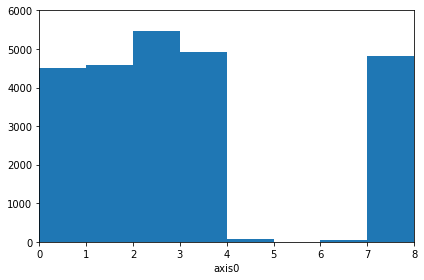

In [56]:
f["all"] = add(one, two, three)
f["all"].physt().plot();